In [4]:
import xarray as xr
import numpy as np

In [5]:
import matplotlib.pyplot as plt

### Open the data

In [8]:
var='mrso'
freq='day'
timeslice='PD'
i='01'
j='0'
diri='/perm/nklm/Px_drought/testing/LENTIS/'

ds, ens_member = open_one_LENTIS(var, freq, timeslice, i, j, diri, plev=None)

In [7]:
ts_mrsos_day, box_seasons = calc_boxstat(ds, 'mrsos', area='rhine')

In [9]:
ts_mrso_day, box_seasons = calc_boxstat(ds, 'mrso', area='rhine')

### Make some plots

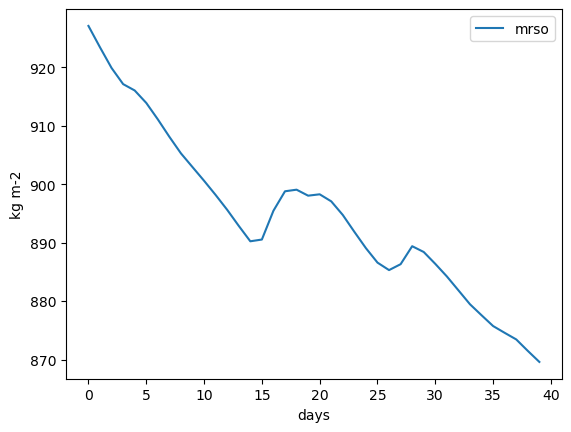

In [22]:

plt.plot(ts_mrso_day[3520:3560], label='mrso')
#plt.plot(ts_mrsos_day[3520:3560], label='mrsos')
plt.ylabel(ds[var].units)
plt.xlabel('days')
plt.legend()

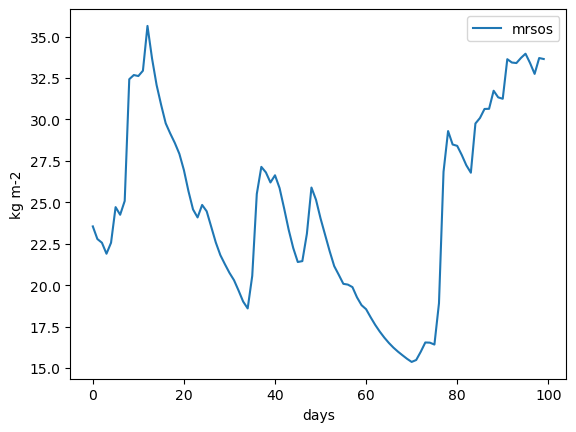

In [24]:
#plt.plot(ts_mrso_day[3520:3560], label='mrso')
plt.plot(ts_mrsos_day[3500:3600], label='mrsos')
plt.ylabel(ds[var].units)
plt.xlabel('days')
plt.legend()

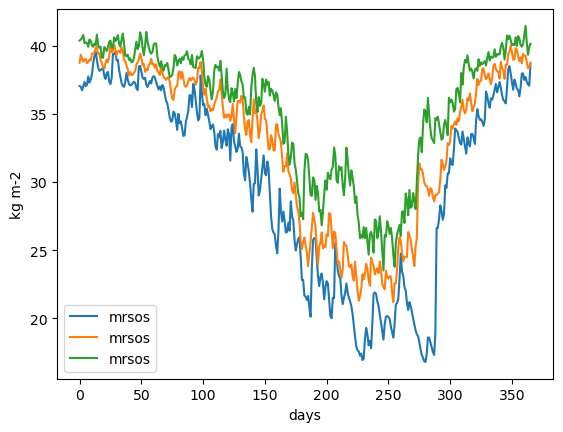

In [46]:
# plt.plot(ts_mrsos_day.groupby(ds.time.dt.season).mean('time'), label='mrsos')
# plt.plot(ts_mrsos_day.groupby(ds.time.dt.day).mean('time'), label='mrsos')
plt.plot(ts_mrsos_day.groupby('time.dayofyear').quantile(0.25, dim='time',method='nearest'), label='mrsos')
plt.plot(ts_mrsos_day.groupby('time.dayofyear').median('time'), label='mrsos')
plt.plot(ts_mrsos_day.groupby('time.dayofyear').quantile(0.75, dim='time',method='nearest'), label='mrsos')
# plt.plot(ts_mrsos_day.resample(time='W').mean(), label='mrsos')
plt.ylabel(ds[var].units)
plt.xlabel('days')
plt.legend()

In [20]:
var='mrso'
ds[var].units

'kg m-2'

#### Have a bunch of necessary definitions

In [1]:
def open_one_LENTIS(var, freq, timeslice, i, j, diri, plev=None):
    """
    Open one LENTIS data file from the ensemle
    """
    if timeslice == 'PD': 
        letter = 'h'
    elif timeslice == '2K': 
        letter = 's'
        
    ens_member=f'{letter}{str(i).zfill(2)}{str(j)}'
    
    file=f"{diri}/{timeslice}/{freq}/{var}/{var}_{ens_member}.nc"
    
    if plev != None:
        ds=xr.open_dataset(file).sel(plev=plev)
    else:
        ds=xr.open_dataset(file)
    
    return ds, ens_member

In [2]:
def calc_boxstat(ds, var, area='global'): 
    """
    Compute spatial weighted mean
    ds      :  xarray DataArray
    """ 
    box_seasons = ds.time.dt.season

    if hasattr(ds, 'lat'):
            weights = np.cos(ds.lat * np.pi / 180)
    elif hasattr(ds, 'latitude'):
            weights = np.cos(ds.latitude * np.pi / 180)

    if area=='global':
        if hasattr(ds, 'lat'):
            boxstat = ds[var].weighted(weights).mean(dim=('lat','lon')) 
        elif hasattr(ds, 'latitude'):
            boxstat = ds[var].weighted(weights).mean(dim=('latitude','longitude')) 
    elif area=='nh':
        if hasattr(ds, 'lat'): 
            boxstat = ds[var].sel(lat=slice(0,90)).weighted(weights).mean(dim=('lat','lon')) 
        elif hasattr(ds, 'latitude'):
            boxstat = ds[var].sel(latitude=slice(0,90)).weighted(weights).mean(dim=('latitude','longitude')) 
    elif area=='europe':
        if hasattr(ds, 'lat'):
            boxstat = ds[var].sel(lat=slice(30,70),lon=slice(-10,40)).weighted(weights).mean(dim=('lat','lon')) 
        elif hasattr(ds, 'latitude'):
            boxstat = ds[var].sel(latitude=slice(30,70),longitude=slice(-10,40)).weighted(weights).mean(dim=('latitude','longitude'))  

    # regions for Pieter Slomp
    elif area in ['rhine',]:
        path_mask = '/perm/nklm/Px_drought/' + area + '.nc'
        basin_mask = xr.open_dataset(path_mask).catchmentID[0,:,:]

        if hasattr(ds, 'lat'):
            boxstat = ds[var].where(basin_mask).weighted(weights).mean(dim=('lat','lon')) 
        elif hasattr(ds, 'latitude'):
            boxstat = ds[var].where(basin_mask).weighted(weights).mean(dim=('latitude','longitude'))   
            
    # regions for Leonie Hemelrijk
    elif area=='LH_westEU':
        if hasattr(ds, 'lat'):
            boxstat = ds[var].sel(lat=slice(30,60),lon=slice(-30,30)).weighted(weights).mean(dim=('lat','lon')) 
        elif hasattr(ds, 'latitude'):
            boxstat = ds[var].sel(latitude=slice(30,60),longitude=slice(-30,30)).weighted(weights).mean(dim=('latitude','longitude'))    
    elif area=='LH_rhine':
        if hasattr(ds, 'lat'):
            boxstat = ds[var].sel(lat=slice(47,55),lon=slice(2,10)).weighted(weights).mean(dim=('lat','lon')) 
        elif hasattr(ds, 'latitude'):
            boxstat = ds[var].sel(latitude=slice(47,55),longitude=slice(2,10)).weighted(weights).mean(dim=('latitude','longitude'))

    else:
        raise ValueError('unknown area: '+area)
            
            
    return boxstat, box_seasons

In [3]:
def get_attr_info(var, freq, timeslice, diri):
    """
    
    """
    ds, ens_member = open_one_LENTIS(var, freq, timeslice, 1, 1, diri)
    
    # get global attributes
    attrs=ds.attrs
    
    # get coordinates
    time_attrs=ds.time.attrs
    lat_attrs=ds.lat.attrs
    lon_attrs=ds.lon.attrs

    # get coordinate bounds 
    time_bnds=ds.time_bnds
    lat_bnds=ds.lat_bnds
    lon_bnds=ds.lon_bnds
    
    # get part of the var attributes
    var_units=ds[var].units
    var_standard_name=ds[var].standard_name
    var_long_name=ds[var].long_name
    
    
    return attrs, time_attrs, time_bnds, var_units, var_standard_name, var_long_name